In [1]:
import numpy as np
from scipy.signal import correlate
import parabolic
import matplotlib.pyplot as plt

C:\Users\Kaushik\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Kaushik\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\Kaushik\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def parabolic_interpolation(f, x):
    """Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.
    f is a vector and x is an index for that vector.
    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.
    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.
    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]
    In [4]: parabolic_interpolation(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def find_periodicity_from_crossings(sig, high_thr, low_thr, fs=1): 
    """
    Estimate frequency by counting crossings of high threshold
    """
    sig = np.array(sig)
    
    # Find all indices right before a rising-edge  
    indices = np.nonzero((sig[1:] >= high_thr) & (sig[:-1] < high_thr))[0]

    # Intersample crossings
    crossings = indices

    # Find periodicity
    return np.mean(np.diff(crossings)) / fs

def find_periodicity_from_autocorr(sig, fs=1):
    """
    Estimate frequency using autocorrelation
    """
    # Calculate autocorrelation and throw away the negative lags
    corr = correlate(sig, sig, mode='full')
    corr = corr[len(corr)//2:]

    # Find the first low point
    d = np.diff(corr)
    if len(np.nonzero(d > 0)[0]) > 0:
        start = np.nonzero(d > 0)[0][0]
    else:
        start = np.argmax(d)

    # Find the next peak after the low point (other than 0 lag).  This bit is
    # not reliable for long signals, due to the desired peak occurring between
    # samples, and other peaks appearing higher.
    # Should use a weighting function to de-emphasize the peaks at longer lags.
    peak = np.argmax(corr[start:]) + start
    peak = min(len(corr)-2, peak)
    px, py = parabolic_interpolation(corr, peak)
    
    # Find periodicity
    return px / fs

def find_periodicity_candidates(sig, high_thr, fs=1):
    T_crossings = find_periodicity_from_crossings(sig, high_thr, fs)
    T_autocorr = find_periodicity_from_autocorr(sig, fs)
    mean_periodicity = np.mean([T_crossings, T_autocorr])
    
    periodicity_candidates = []
    if not np.isnan(T_crossings):
        periodicity_candidates.append(np.round(T_crossings))
    if not np.isnan(T_autocorr):
        periodicity_candidates.append(np.round(T_autocorr))   
    if not np.isnan(mean_periodicity):
        periodicity_candidates.append(np.round(mean_periodicity))
        
    return list(np.unique(periodicity_candidates))

In [3]:
ts_1 = [0,0,0,50,0,0,0,100,0,0,0,50,0,0,0,100,0,0,0,50,0,0,0,100,0,0,0,50,0,0,0,100,0,0,0,50,0,0,0,100]

ts_2 = [0,0,0,50,0,0,100,0,0,0,50,0,0,100,0,0,0,50,0,0,100,0,0,0,50,0,0,100,0,0,0,50,0,0,100]

ts_3 = [0,0,0,50,0,0,100,0,0,0,50,0,0,200,0,0,0,50,0,0,100,0,0,0,50,0,0,200,0,0,0,50,0,0,100]

ts_4 = [0,0,0,50,0,0,0,100,0,0,0,200,0,0,0,100,0,0,0,50,0,0,0,100,0,0,0,200,0,0,0,100,0,0,0,50,0,0,0,100]

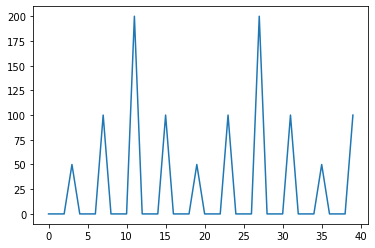

In [4]:
ts = ts_4
plt.plot(ts);

In [5]:
ts_sorted = sorted(np.unique(ts), reverse=True)
high_thr = np.mean([np.quantile(ts, 0.95), np.mean([ts_sorted[0],ts_sorted[1]])])
print(high_thr)

127.49999999999986


In [6]:
find_periodicity_candidates(ts, high_thr)

[4.0, 10.0, 16.0]

In [14]:
final_freq_list_for_arima = np.array([1, 2, 3, 4, 6, 8, 12, 26, 52])
final_freq_list_for_arima = list(final_freq_list_for_arima[final_freq_list_for_arima <= len(ts)/2])
final_freq_list_for_arima.extend(find_periodicity_candidates(ts, high_thr))
final_freq_list_for_arima = list(np.unique(final_freq_list_for_arima))
final_freq_list_for_arima

[1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 10.0, 12.0, 16.0]